In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/finaldataset/FinalDataset.csv


# Star Rating prediction (Re-iterated)

**Before getting into what new is present in this version, lets have a look how far we have come!!**

[Part-1: Data Analysis & Preprocessing](https://www.kaggle.com/rajatagg/star-rating-prediction-part-1?scriptVersionId=84763077) 

[Part-2: Feature vector generation using Multinomial Naive Bayes Classifier](https://www.kaggle.com/rajatagg/star-rating-prediction-part-2) 

[Part-3: Training & Testing using Random Forest Algorithm](https://www.kaggle.com/rajatagg/starratingprediction-part-3/notebook) 

[Part-4: Comparing performance(F1-Score) of Naive Bayes classifiers with N-grams & different review lengths](https://www.kaggle.com/code/rajatagg/star-rating-prediction-part-4) 

[Part-5: Undersampling Data to handle class Imbalance - got only 1% increase in performance for NB](https://www.kaggle.com/code/rajatagg/star-rating-prediction-part-5)

# Observations 
> **I have trained our models on very short review lengths of around 75 which comprises of 10-15 words per review at maximum.**

> **I got a F1-Score of 0.63 for NaiveBayes with Bi-grams. I found that this model was very poor in generalizing i.e. poor performance of prediction on unseen samples.**

> **On analyzing the dataset again, I found that a lot spelling errors are present and thereby causing bad redundancy.
e.g. excelente, excelllllente, woooowwwww, ammmaazinggg, goooooodd, gggooodddd etc. This kind of words were present in about ~30k reviews having 5 star label and many different words for labels as well.**

> **I used spelling correction algorithm from Wordnet module of NLTK but that was too slow. It took more than 9 hours to correctly spell the words from the corpus having 200k reviews while spelling correction algorithm comes with its error based on its capability.**

# What I done to overcome these challenges

> **I used spelling correction algorithm from [SymSpell library](https://github.com/wolfgarbe/SymSpell) which reduced that 9 hours time to mere 30 mins. It is much faster and accurate as compared to [NLTK](https://www.nltk.org/howto/wordnet.html) WordNet. Though for the next step, I have used Wordnet after applying SymSpell once.**


> **I used Repeated Characters Replacement Algorithm using NLTK that basically takes a word closer to the actual word by removing the repeated letters e.g. woooooowwwww -> wow, gooood -> good, exceellleeent -> excellent etc. This solves our problem to a major extent as it will reduce redundant features that are counted different due to repeated letter occurence.**

> **I had earlier used WordNet lemmatizer but it's not found to be effective. So, I used SpaCy Lemmatizer which is much more effective but a bit more time consuming.**

# Results

> **Implementing SymSpell Spelling Correction, Repeated Characters Replacement and SpaCy lemmatizer. Now, my model for Multinomial Naive Bayes with Bi-grams is able to generalize much better than the earlier one and is able to make accurte predictions for reviews 200-250 having upto 40-50 words. I got a F1-Score of 0.74 which may be further improved.**.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# importing the required libraries
import numpy as np 	# linear algebra
import pandas as pd 	# data processing, CSV file I/O (e.g. pd.read_csv)

import nltk 	# natural language tool kit for text preprocessing
import re 	# regular expression
import spacy # stronger lemmatization
sp = spacy.load('en_core_web_sm') # english language model
from nltk.tokenize import RegexpTokenizer 	# tokenization
from wordcloud import wordcloud		# plot words 
from nltk.tokenize import RegexpTokenizer # for tokenization using regular exp
from nltk.stem.wordnet import WordNetLemmatizer # for lemmatization
from nltk.corpus import wordnet # replace repeated words

from textblob import TextBlob # for spelling correction

 
!pip install -U symspellpy
import pkg_resources
from symspellpy import SymSpell, Verbosity # efficient spelling correction
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
) 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
    
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 KB 8.3 MB/s eta 0:00:00


In [3]:
df = pd.read_csv("/kaggle/input/finaldataset/FinalDataset.csv")

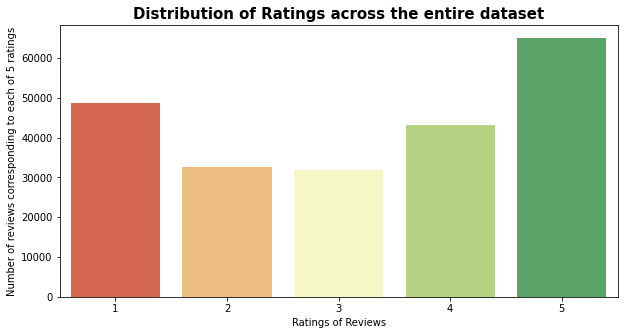

In [4]:
plt.figure(figsize=(10,5))
sns.countplot(df['Rating'], palette=sns.color_palette("RdYlGn", 5))
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();

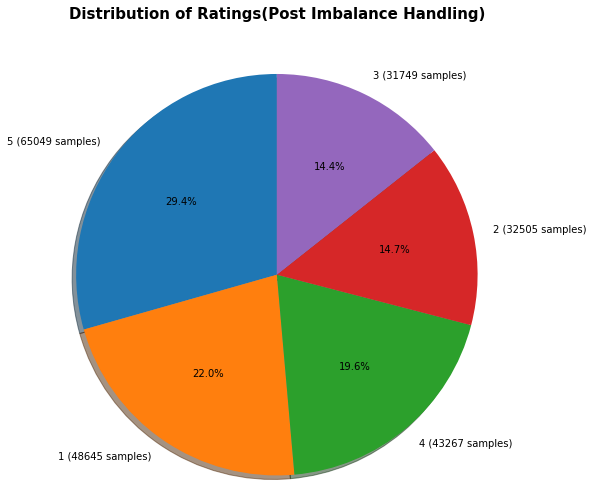

In [5]:
labels = [f'{k} ({df["Rating"].value_counts()[k]} samples)' for k in df['Rating'].value_counts().keys()]
sizes = dict(df['Rating'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of Ratings(Post Imbalance Handling)",pad=40, fontweight='bold', fontsize=15)
plt.show();

In [6]:
# function to count characters in a list of strings
def getWordCount(text):
    word_count = 0
    for word in text.split():
        word_count += 1
    return word_count

def getReviewLength(text):
    review_length = 0
    for word in text.split():
        review_length += len(word)
    return review_length

In [7]:
df.dropna(inplace=True)

In [8]:
df['review_length'] = df['Reviews'].apply(getReviewLength)
df['word_count'] = df['Reviews'].apply(getWordCount)

In [9]:
df.shape

(221215, 4)

In [10]:
df.head()

,Rating,Reviews,review_length,word_count
0,4,work good but go slow sometimes but a very goo...,47,12
1,4,great phone to replace lose phone only thing v...,135,30
2,2,charge port loose get that solder in then need...,125,31
3,2,phone look good but not stay charge have to bu...,110,26
4,3,battery life great very responsive to touch on...,121,25


In [11]:
cp = df[df['word_count'] > 20]

In [12]:
cp.shape

(46413, 4)

In [13]:
df.dropna(inplace=True)

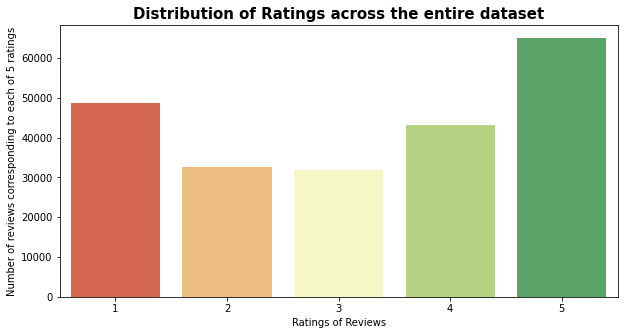

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(df['Rating'], palette=sns.color_palette("RdYlGn", 5))
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();

>**There is one more challenge I found that the reviews for rating 4 and 3 are comparably lengthier.**

In [15]:
 df.head()

,Rating,Reviews,review_length,word_count
0,4,work good but go slow sometimes but a very goo...,47,12
1,4,great phone to replace lose phone only thing v...,135,30
2,2,charge port loose get that solder in then need...,125,31
3,2,phone look good but not stay charge have to bu...,110,26
4,3,battery life great very responsive to touch on...,121,25


In [16]:
# Make sure to install symspellpy package separately
# installing dependencies to use sym spell library


'''
This class definition for 'RepeatReplacer' which have methods to replace repeated words
until a valid word is found, is as follows:
    replacer.replace('looooove') -> 'love'
    replacer.replace('oooooh') ->  'ooh'

'''

class RepeatReplacer(object):
    
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word
            
        repl_word = self.repeat_regexp.sub(self.repl, word)
    
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word



'''
This class definition for 'TextDataPreprocessor' which have methods to perform text preprocessing
is as follows:

Data members-

contraction_mapping: List of words to expand contractions.
                    e.g. I can't -> I can not, I'd -> I would etc
stop_words: List of words that are found to be repeating very often.
                    e.g. the, is, was, I, she, he etc

Methods-(all the functions accept and return string)

expandContractions(): expands contractions if any.
tokenization():  removes urls, handles, numeric digits and special characters while retaining alphabets.
removeStopwords(): removes stop words.
spellingCorrectionTextBlob(): corrects spelling errors using TextBlob library(weaker and much slower).
spellingCorrectionSymSpell(): corrects spelling errors and supports word segmentation too(much much faster).
                              (Make sure symspellpy package is installed (!pip install -U symspellpy)
lemmatizeTextWordNet(): converts the word to the base lemma(weaker but faster).
lemmatizeTextSpacy(): converts the word to the base lemma(stronger but slightly slower).
preprocessReview(): encapsulated all the functions together in it.
preprocessReviewPrintingSteps(): similar to preprocessReview(), it prints intermediate steps of preprocessing.
'''

class TextDataPreprocessor:
    
 
    def __init__(self, text=""):
        self.text = ""
        # instantiating the object for spelling correction 
        self.sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
        self.sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
        self.replacer = RepeatReplacer()
        #self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = RegexpTokenizer("[a-zA-Z]+", discard_empty=True)
        self.contraction_mapping = {"ain't": "not", "aren't": "are not","can't": "can not", 'cannot':'can not',"'cause": "because",
        "could've": "could have", "couldn't": "could not", "didn't": "did not",
        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
        "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
        "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
        "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
        "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is",
        "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
        "mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
        "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
        "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
        "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
        "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
        "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": 
        "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", 
        "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
        "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
        "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
        "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
        "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
        "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
        "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
        "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
        "you're": "you are", "you've": "you have" }

        self.stop_words= ['yourself','yourselves','herself', 'themselves', 'himself', 'ourselves',
        'myself', 'between', 'whom', 'is', "she", 'here', 'your', 'each', 'we', 'he',
        'my', 'you', 'are', 'them', 'other','and', 'an', 
        'their', 'can', 'she', 'these', 'ours', 
        'while', 'have', 'when', 'were',
        'who', 'they', 'has', 'before',
        'yours', "it", 'on',  'now', 'her', 'an', 'from', 
        "would",'how', 'the', 'or', 
        'doing','his',  'was', 'through', 'own', 'theirs', 
        'me',  'him', 'be', 'same',
        'it', 'its', 'which', 'there','our', 'this', 'hers', 'being', 
        'did','those', 'i',
        'does', 'will', 'shall', 's','t','n','d', 'e','u', 'x','am','get','ve']
        
    '''
    # to be used with contractions library and that needs to be installed every time so to avoid that
    def expandContractions(text): 
        expandedText = contractions.fix(text)
        return expandedText
    '''

    def expandContractions(self, text):
        updatedtext = ""
        for word in text.split():
            if word in self.contraction_mapping:
                updatedtext += self.contraction_mapping[word] + " "
            else:
                updatedtext += word + " "
                
        return updatedtext[:-1]

    
    def tokenization(self, text):
        text = re.sub(r'www','https',text)
        text = re.sub(r'http[^\s]+','',text)
        text = re.sub('@[^\s]+','',text)
        text = self.tokenizer.tokenize(text)
        text = " ".join(text)
        return text.lower()
    
    
    def removeStopwords(self, text):
        updatedtext = ""
        for word in text.split():
            if(word not in self.stop_words):
                updatedtext += word + " "

        return updatedtext[:-1]


    
         
    def spellingCorrectionTextBlob(self, review):    
        review = TextBlob(review)
        review = review.correct()
        return str(review)


    

 
    def spellingCorrectionSymSpell(self, text):
        ans = ""

        for word in text.split():

            # checking for the spelling correction, returns empty ,if it didnt find a word
            # because include_unknown parameter (when false)
            # reason might be the words having repeated characters like gooooooood, excelllleeeeeeent etc
            # which go beyond the edit_distance of 2

            suggestions = self.sym_spell.lookup(word, Verbosity.TOP, max_edit_distance=2, include_unknown=False)

            if(len(suggestions) == 0):
                text = self.replacer.replace(word)

                # if still after correction the word is not found, we will skip that word(include_unk = True)
                suggestions = self.sym_spell.lookup(text, Verbosity.TOP, max_edit_distance=2, include_unknown=True)

            if(len(suggestions) > 0):
                text = str(suggestions[0])
                text = re.search(r'[a-zA-Z]+',str(text))
                ans += (text.group()) + " "

        return ans[:-1]


    
    
    def lemmatizeTextWordNet(self, text):
        lemmatizedList = ""
        for word in text.split():
            lem_word = self.lemmatizer.lemmatize(word)
            lemmatizedList += lem_word
        return " ".join(lemmatizedList)
    

    #(SpaCy lemmatizer is much more accurate but takes longer than nltk)
    def lemmatizeTextSpacy(self, text):
        lemmatizedList = ""
        text = sp(text)
        for word in text:
            lem_word = word.lemma_
            lemmatizedList += lem_word + " "
        return lemmatizedList[:-1]

   
    def preprocessReview(self, review):
        expanded_review = self.expandContractions(review)
        tokenized_review = self.tokenization(expanded_review)
        removed_stopwords_review = self.removeStopwords(tokenized_review)
        spellChecked_review = self.spellingCorrectionSymSpell(removed_stopwords_review)
        lemmatized_review = self.lemmatizeTextSpacy(spellChecked_review)
        return lemmatized_review
    
    def preprocessReviewPrintingSteps(self, review):
        print("The review entererd is:\n", review,"\n")
        expanded_review = self.expandContractions(review)
        print("Step-1 : expanding contractions: \n",expanded_review,"\n")
        tokenized_review = self.tokenization(expanded_review)
        print("Step-2 : tokenization:\n", tokenized_review,"\n")
        removed_stopwords_review = self.removeStopwords(tokenized_review)
        print("Step-3 : removing stop words:\n", removed_stopwords_review,"\n")
        spellChecked_review = self.spellingCorrectionSymSpell(removed_stopwords_review)
        print("Step-4 : possible repeated letters replacement & spelling correction:\n", spellChecked_review,"\n")
        lemmatized_review = self.lemmatizeTextSpacy(spellChecked_review)
        print("Step-5 : applying lemmatization:\n", lemmatized_review,"\n")
        return lemmatized_review

> **I have separately preprocessed my entire dataset. The above implementations are to test unseen samples. Keep going :)**

> **Splitting the dataset to train and test set**

In [17]:
# splitting the dataset into train and test data(70:30)
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Rating'], test_size=.30, random_state=1, stratify=df['Rating'])


#Concatenating the training instances (reviews and target Variable)
traindf = pd.concat([X_train, y_train], axis = 1, ignore_index = False)
traindf.reset_index(drop=True, inplace=True)
testdf = pd.concat([X_test, y_test], axis = 1, ignore_index = False)
testdf.reset_index(drop=True, inplace=True)

#traindf['Reviews'] = train['Reviews'].apply(obj.preprocess_review)
#adding two attributes temporarily for analysing review length
# to delete lengthier reviews, they don't contribute much to the cause
#traindf.drop(index_names, inplace = True)


**The class definition for 'TrainTestModel' class which have methods to perform text preprocessing
is as follows:**

Data members-
    
    vectorizer: tf-idf object
    
    model: Naive Bayes object
    
    ngram: int variable to specificy unigrams(=1), bigrams(=2), trigrams(=3) etc

Methods-(all the functions accept and return string)

    trainMyModel():   
    
    testMyModel():  
    
    getVectorizerAndModel(): 

In [18]:
class TrainTestModel:
    
    # function to instantiate the vectorizer and model
    # Tf-idf for vectorizer
    # Multinomial Naive Bayes or Random Forest(Be Careful about imports and instantiation)
    # ngrams e.g. ngram=2, [great product],[not bad],[is great] etc
    
    def __init__(self, ngram1=1, ngram2=1):    
        
         
        # instantiate the tf-idf vectorizer
        self.vectorizer = TfidfVectorizer(ngram_range=(ngram1,ngram2))
        
        # could have added a var to switch b/w diff algos rather than commenting and uncommenting...Your HomeWork
        self.model = RandomForestClassifier(n_estimators = 75,criterion="entropy",random_state = 42)
        
        #self.model = MultinomialNB()
        self.nums = ['1','2','3','4','5']
        
     
   
    def trainMyModel(self, reviews, rating):
    
        '''
        Inputs-
            vectorizer: instantiated vectorizer, to build feature vector from test reviews
            model: instantiated model, to train.
            reviews: pandas datastructure having review text strings
            rating: stack of rating(Pandas series or dataframe column).
            
        e.g. obj.trainMyModel(fvector, dataframe['Rating'],0)

        Output-
            print the classfication report.
        '''
        
        # generating feature vector
        vectorized = self.vectorizer.fit_transform(reviews)

        # type casted to numpy array
        fvector = vectorized.toarray()
                
        # learn the features, training
        self.model.fit(fvector,rating)

        # make predictions
        y_pred = self.model.predict(fvector)

        # performance metrics
        classification_score = classification_report(rating, y_pred, target_names=self.nums)

        print(classification_score)
        
        return y_pred
    
    def testMyModel(self,reviews, rating):

        '''
        Inputs-
            vectorizer: to build feature vector from test reviews.
            model: trained model to make predictions.
            reviews: stack of reviews(Pandas series or dataframe column).
            rating: stack of rating(Pandas series or dataframe column).
        Output-
            print the classfication report
        '''
        # generating feature vector
        vectorized = self.vectorizer.transform(reviews)

        # type casted to numpy array
        fvector = vectorized.toarray()
 
        # make predictions using (pre)trained model
        y_pred = self.model.predict(fvector)

        # print performance metrics
        classification_score = classification_report(rating, y_pred, target_names=self.nums)

        print(classification_score)
        
        return y_pred
    
    
    
    def getVectorizerAndModel(self):
        return self.vectorizer, self.model

In [19]:
df['Rating'] = df['Rating'].astype(str)

> **Instantiating the object with N-gram size**

In [20]:
ttm = TrainTestModel(1,1)

> **applying training function**

In [21]:
%%time
ttm.trainMyModel(traindf['Reviews'], traindf['Rating'])

              precision    recall  f1-score   support

           1       0.99      1.00      0.99     34051
           2       0.99      0.98      0.98     22754
           3       0.99      0.94      0.96     22224
           4       0.93      0.96      0.94     30287
           5       0.97      0.98      0.98     45534

    accuracy                           0.97    154850
   macro avg       0.98      0.97      0.97    154850
weighted avg       0.97      0.97      0.97    154850

CPU times: user 24min 6s, sys: 19.3 s, total: 24min 25s
Wall time: 24min 27s


array([3, 4, 1, ..., 4, 3, 1])

> **getting the vectorizer and model used for training and testing**

In [22]:
vectorizer, model = ttm.getVectorizerAndModel()

> **applying testing function**

In [23]:
ttm.testMyModel(testdf['Reviews'], testdf['Rating'])

              precision    recall  f1-score   support

           1       0.85      0.96      0.90     14594
           2       0.97      0.89      0.93      9751
           3       0.93      0.75      0.83      9525
           4       0.85      0.82      0.83     12980
           5       0.91      0.96      0.94     19515

    accuracy                           0.89     66365
   macro avg       0.90      0.88      0.89     66365
weighted avg       0.90      0.89      0.89     66365



array([5, 3, 2, ..., 5, 5, 5])

> **function to save the model and vectorizer for future use.**

In [24]:
def saveJoblibModel(vectorizer_name, model_name):    
    joblib.dump(model, "modelRF.sav")
    joblib.dump(vectorizer, "vectorizerRF.sav")

In [25]:
saveJoblibModel(vectorizer, model)

> **function to load them from the notebook**

In [26]:
def loadingJoblibSavedModel(vectorizer_name, model_name,path):
    vectorizer = joblib.load(path+vectorizer_name+".sav")
    model = joblib.load(path+model_name+".sav")
    return vectorizer, model

> **function to generate a star rating for an arbitrary mobile phone review**

In [27]:
def getStarRating(ttm, tdp,review):
    
    '''
    Inputs-
        ttm: object from TrainTestModel class to get  vectorizer and Model
        tpp : preprocessor Object to preprocess the review
        review: string 
        
    Outputs-
        predicted star rating for a review
    '''
    vectorizer, model = ttm.getVectorizerAndModel()
    preprocessed_review = tdp.preprocessReviewPrintingSteps(review)
    features = vectorizer.transform([preprocessed_review])
    feature_vector = features.toarray()
    predicted_class = model.predict(feature_vector)
    print("Predicted Review Rating is: ",predicted_class,"\n")
    return predicted_class

> **I need to generate the text data preprocessing object to perform expanding contractions, tokenization,lowercasing,, removing stopwords, spelling correction, repeated letters replacement and lemmatization.**

> **List of stop words and contractions map is included in this object.**

In [28]:
tdp = TextDataPreprocessor()

In [29]:
#text = input("Enter a review: \n")
text = "whattt a nice product !!!! but I expected much better performance"
getStarRating(ttm, tdp, text)

The review entererd is:
 whattt a nice product !!!! but I expected much better performance 

Step-1 : expanding contractions: 
 whattt a nice product !!!! but I expected much better performance 

Step-2 : tokenization:
 whattt a nice product but i expected much better performance 

Step-3 : removing stop words:
 whattt a nice product but expected much better performance 

Step-4 : possible repeated letters replacement & spelling correction:
 what a nice product but expected much better performance 

Step-5 : applying lemmatization:
 what a nice product but expect much well performance 

Predicted Review Rating is:  [5] 



array([5])

In [30]:
#text = input("Enter a review: \n")
text = "battery is averageee, displayy is not smooth , heavier, so I wouldn't recommend"
getStarRating(ttm, tdp, text)

The review entererd is:
 battery is averageee, displayy is not smooth , heavier, so I wouldn't recommend 

Step-1 : expanding contractions: 
 battery is averageee, displayy is not smooth , heavier, so I would not recommend 

Step-2 : tokenization:
 battery is averageee displayy is not smooth heavier so i would not recommend 

Step-3 : removing stop words:
 battery averageee displayy not smooth heavier so not recommend 

Step-4 : possible repeated letters replacement & spelling correction:
 battery average display not smooth heavier so not recommend 

Step-5 : applying lemmatization:
 battery average display not smooth heavy so not recommend 

Predicted Review Rating is:  [2] 



array([2])

In [31]:
#text = input("Enter a review: \n")
text = "battery backup is quite fine, sound is awesome , lookwise its fine but it hangs very often"
getStarRating(ttm, tdp, text)

The review entererd is:
 battery backup is quite fine, sound is awesome , lookwise its fine but it hangs very often 

Step-1 : expanding contractions: 
 battery backup is quite fine, sound is awesome , lookwise its fine but it hangs very often 

Step-2 : tokenization:
 battery backup is quite fine sound is awesome lookwise its fine but it hangs very often 

Step-3 : removing stop words:
 battery backup quite fine sound awesome lookwise fine but hangs very often 

Step-4 : possible repeated letters replacement & spelling correction:
 battery backup quite fine sound awesome clockwise fine but hangs very often 

Step-5 : applying lemmatization:
 battery backup quite fine sound awesome clockwise fine but hang very often 

Predicted Review Rating is:  [4] 



array([4])

In [32]:
#text = input("Enter a review: \n")
text = "overall a great product but still I need something better"
getStarRating(ttm, tdp, text)

The review entererd is:
 overall a great product but still I need something better 

Step-1 : expanding contractions: 
 overall a great product but still I need something better 

Step-2 : tokenization:
 overall a great product but still i need something better 

Step-3 : removing stop words:
 overall a great product but still need something better 

Step-4 : possible repeated letters replacement & spelling correction:
 overall a great product but still need something better 

Step-5 : applying lemmatization:
 overall a great product but still need something well 

Predicted Review Rating is:  [5] 



array([5])

In [33]:
#text = input("Enter a review: \n")
text = "awessommmmee !!!!! best from the samsung's collection....I wait for the next"
getStarRating(ttm, tdp, text)

The review entererd is:
 awessommmmee !!!!! best from the samsung's collection....I wait for the next 

Step-1 : expanding contractions: 
 awessommmmee !!!!! best from the samsung's collection....I wait for the next 

Step-2 : tokenization:
 awessommmmee best from the samsung s collection i wait for the next 

Step-3 : removing stop words:
 awessommmmee best samsung collection wait for next 

Step-4 : possible repeated letters replacement & spelling correction:
 awesome best samsung collection wait for next 

Step-5 : applying lemmatization:
 awesome good samsung collection wait for next 

Predicted Review Rating is:  [5] 



array([5])

In [34]:
#text = input("Enter a review: \n")
text = "camera quality and disssplay areee baddd but sound was goooood...anddd it never gets lagggy,,,fingerprint scanner finds diffivult to detect my fingerprints"
getStarRating(ttm, tdp, text)

The review entererd is:
 camera quality and disssplay areee baddd but sound was goooood...anddd it never gets lagggy,,,fingerprint scanner finds diffivult to detect my fingerprints 

Step-1 : expanding contractions: 
 camera quality and disssplay areee baddd but sound was goooood...anddd it never gets lagggy,,,fingerprint scanner finds diffivult to detect my fingerprints 

Step-2 : tokenization:
 camera quality and disssplay areee baddd but sound was goooood anddd it never gets lagggy fingerprint scanner finds diffivult to detect my fingerprints 

Step-3 : removing stop words:
 camera quality disssplay areee baddd but sound goooood anddd never gets lagggy fingerprint scanner finds diffivult to detect fingerprints 

Step-4 : possible repeated letters replacement & spelling correction:
 camera quality display arete baddy but sound godhood and never gets lagged fingerprint scanner finds difficult to detect fingerprints 

Step-5 : applying lemmatization:
 camera quality display arete baddy

array([1])

In [35]:
#text = input("Enter a review: \n")
text = "it has varietty of features but only few of them works fine.....but can be used to make voice calls "
getStarRating(ttm, tdp, text)

The review entererd is:
 it has varietty of features but only few of them works fine.....but can be used to make voice calls  

Step-1 : expanding contractions: 
 it has varietty of features but only few of them works fine.....but can be used to make voice calls 

Step-2 : tokenization:
 it has varietty of features but only few of them works fine but can be used to make voice calls 

Step-3 : removing stop words:
 varietty of features but only few of works fine but used to make voice calls 

Step-4 : possible repeated letters replacement & spelling correction:
 variety of features but only few of works fine but used to make voice calls 

Step-5 : applying lemmatization:
 variety of feature but only few of work fine but use to make voice call 

Predicted Review Rating is:  [4] 



array([4])

# **Still I think a lot can done to improve the performance using Multinomial Naive-Bayes Algorithm. But I will stop this here. I will focus on deployment and handling it in production environment. :) Good Luck**

In [36]:
joblib.dump(model, "modelRF.sav")
joblib.dump(vectorizer, "vectorizerRF.sav")

['vectorizerRF.sav']

# **Performance metrics after undersampling ,oversampling and spelling based improvements**

<div>
<div style="float:left">
<table style="border: 0.3px solid black">
  <tr>
      <th style="text-align:center" colspan="5">Score of Trainig data</th>
    </tr>
    <tr style="border: 0.1px solid black">
    <th>Algorithms</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
    <tr>
    <td>NaiveBayes,Unigram</td>    
    <td>0.64</td>
    <td>0.64</td>
    <td>0.64</td>
    <td>0.62</td>
    </tr>
  <tr>
    <td>NaiveBayes,Bigram</td> 
   <td>0.82</td>
    <td>0.84</td>
    <td>0.85</td>
    <td>0.81</td>
  </tr>
  <tr>
    <td>Random Forest(10 learners)</td>
    <td>0.96</td>
    <td>0.96</td>
    <td>0.96</td>
    <td>0.96</td>
  </tr>
    <tr>
    <td>Random Forest(25 learners)</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
  </tr>
    <tr>
    <td>Random Forest(50 learners)</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
  </tr>
    <tr>
    <td>Random Forest(50 learners)</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
    <td>0.97</td>
  </tr>
</table>
    </div>
    
    
    
 <div style="float:right">
<table style="border: 0.3px solid black">
     <tr>
      <th style="text-align:center" colspan="5">Score of Test data</th>
    </tr>
  <tr style="border: 0.1px solid black">
    <th>Algorithms</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
    <tr>
    <td>NaiveBayes,Unigram</td>    
    <td>0.62</td>
    <td>0.61</td>
    <td>0.62</td>
    <td>0.60</td>
    </tr>
  <tr>
    <td>NaiveBayes,Bigram</td>   
    <td>0.75</td>
    <td>0.77</td>
    <td>0.75</td>
    <td>0.74</td>
  </tr>
  <tr>
    <td>Random Forest(10 learners)</td> 
    <td>0.86</td>
    <td>0.86</td>
    <td>0.86</td>
    <td>0.86</td>
  </tr>
    <tr>
    <td>Random Forest(25 learners)</td>
    <td>0.87</td>
    <td>0.87</td>
    <td>0.87</td>
    <td>0.87</td>
  </tr>
    <tr>
    <td>Random Forest(50 learners)</td>
    <td>0.89</td>
    <td>0.89</td>
    <td>0.89</td>
    <td>0.89</td>
  </tr>
</table>
          </div>
    </div>

# **Performance metrics based on our previous work [Part-4](https://www.kaggle.com/code/rajatagg/star-rating-prediction-part-4)**

<div>
<div style="float:left">
<table style="border: 0.3px solid black">
  <tr>
      <th style="text-align:center" colspan="5">Score of Trainig data</th>
    </tr>
    <tr style="border: 0.1px solid black">
    <th>(Ngram, Review Length(less than))</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
    <tr>
    <td>Unigram, 75</td>    
    <td>0.76</td>
    <td>0.76</td>
    <td>0.76</td>
    <td>0.70</td>
  </tr>
  <tr>
    <td>Unigram, 50</td>   
      <td>0.78</td>
    <td>0.77</td>
    <td>0.78</td>
      <td>0.73</td>
  </tr>
  <tr>
    <td>Bigram, 50</td> 
   <td>0.83</td>
    <td>0.85</td>
    <td>0.83</td>
    <td>0.80</td>
  </tr>
  <tr>
    <td>Unigram, 25</td>
    <td>0.81</td>
    <td>0.80</td>
    <td>0.81</td>
    <td>0.76</td>
  </tr>
  <tr>
    <td>Bigram, 25</td>
    <td>0.83</td>
    <td>0.84</td>
    <td>0.83</td>
    <td>0.79</td>
  </tr>
  <tr>
    <td>Trigram, 25</td> 
    <td>0.78</td>
    <td>0.83</td>
    <td>0.78</td>
    <td>0.73</td>
  </tr>
</table>
    </div>
    
    
    
 <div style="float:right">
<table style="border: 0.3px solid black">
     <tr>
      <th style="text-align:center" colspan="5">Score of Test data</th>
    </tr>
  <tr style="border: 0.1px solid black">
    <th>(Ngram, Review Length(less than))</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
    <tr>
    <td>Unigram, 75</td>    
    <td>0.68</td>
    <td>0.64</td>
    <td>0.68</td>
    <td>0.63</td>
    </tr>
  <tr>
    <td>Unigram, 50</td>   
    <td>0.66</td>
    <td>0.62</td>
    <td>0.66</td>
    <td>0.62</td>
  </tr>
  <tr>
    <td>Bigram, 50</td> 
    <td>0.70</td>
    <td>0.70</td>
    <td>0.70</td>
    <td>0.63</td>
  </tr>
    <tr>
    <td>Unigram, 25</td>
    <td>0.62</td>
    <td>0.59</td>
    <td>0.62</td>
    <td>0.59</td>
  </tr>
  <tr>
    <td>Bigram, 25</td>
    <td>0.66</td>
    <td>0.62</td>
    <td>0.66</td>
    <td>0.59</td>
  </tr>
  <tr>
    <td>Trigram, 25</td> 
    <td>0.58</td>
    <td>0.61</td>
    <td>0.58</td>
    <td>0.46</td>
  </tr>
</table>
          </div>
    </div>